### Term Project
## Instructions

* A dataset of animal images (4 classes). (download it from Microsoft Teams Term Project Assignment Page. It has one folder for each class.)
* You are encouraged to use Python. But other languages will be accepted.
* You will perform image classification. You’re expected to use transfer learning (e.g. AlexNet, VGG, ResNet etc ) and compare the results with the version w/o transfer learning, i.e. Transfer learning vs. training from scratch.
* You’re expected to use visualization tools (training curves, correct/miss classification comparison images, result comparison graphs etc).
* **Group work is not allowed**.
* You’re expected to use best practices we have seen in the lecture such as hyperparameter search, cross-validation, regularization etc.
* Grading will depend on the level of your elaboration.
* If you are submitting a Python notebook please write your comments (about models, hyperparameters, results) on the notebook as **markdown** (you can check [this](https://www.markdownguide.org/cheat-sheet/) for markdown tutorial.).
* If you are not using a Python notebook, then, with your code file, please submit a separate report (pdf file) and show your results and add your comments.

# Deadline, June 7, 5 PM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
from torchvision.transforms import ToTensor, Resize, Normalize
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
preprocess = transforms.Compose([
    Resize((224, 224)),  # Resize the image to a fixed size
    ToTensor(),          # Convert the image to a tensor
    Normalize(           # Normalize the image tensor
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/dataset', transform=preprocess)

In [6]:
#Dividing the dataset into training and testing sets
train_size = 0.8
train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, shuffle=True)

In [7]:
print(len(train_dataset))

1120


In [8]:
print(len(test_dataset))

280


In [9]:
#Creating data loaders for training and testing
batch_size = 64
shuffle = True
num_workers = 2

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [23]:
#Same training function as last time for our log-loss network
def train_log_loss_network(model, train_loader, val_loader=None, epochs=20, device="cpu"):
  loss_fn = nn.CrossEntropyLoss() #CrossEntropy is another name for the Logistic Regression loss function. Like before, we phrase learning as minimize a loss function. This is the loss we are going to minimize!

  #We need an optimizer! Adam is a good default one that works "well enough" for most problems
  #To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  optimizer = torch.optim.Adam(model.parameters())

  #Pred
  pred_list = []

  #Target
  target_list = []

  #Loss List for visulizing
  lost_list = []

  #Accuracy List
  accuracy_list = []

  #Devices can be spcified by a string, or a special torch object
  #If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

  model.to(device)#Place the model on the correct compute resource
  for epoch in range(epochs):

    model = model.train()#Put our model in training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

      #Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute loss.
      loss = loss_fn(y_pred, labels.long())

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else:#Lets find out validation performance as we go!
      model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

      predictions = []
      targets = []

      for inputs, labels in test_loader:

        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        #We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        pred_list.append(predictions)
        for l in labels.cpu().numpy():
          targets.append(l)
        target_list.append(targets)
      #print("Network Accuracy: ", )
      print("Loss after epoch {} is {}. Accuracy: {}".format(epoch, running_loss, accuracy_score(predictions, targets)))
      lost_list.append(running_loss)
      accuracy_list.append(accuracy_score(predictions, targets))
  return lost_list, accuracy_list, pred_list, target_list

In [24]:
# Load pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

accuracy_list_vgg16 = []

lost_list_vgg16 = []

pred_list_vgg16 = []

target_list_vgg16 = []

# Freeze model parameters
for param in vgg16.parameters():
    param.requires_grad = False

# Add custom layers to the model
num_features = vgg16.classifier[6].in_features
custom_layers = [
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, len(dataset.classes)),
    nn.LogSoftmax(dim=1)
]
vgg16.classifier[6] = nn.Sequential(*custom_layers)

lost_list_vgg16, accuracy_list_vgg16, pred_list_vgg16, target_list_vgg16 = train_log_loss_network(vgg16, train_loader, val_loader=test_loader, epochs=20, device=DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss after epoch 0 is 492.6101881740324. Accuracy: 1.0
Loss after epoch 1 is 58.61652676715312. Accuracy: 1.0
Loss after epoch 2 is 34.16997084543618. Accuracy: 1.0
Loss after epoch 3 is 19.773381404185784. Accuracy: 1.0
Loss after epoch 4 is 4.209439393893234. Accuracy: 1.0
Loss after epoch 5 is 45.4554642990515. Accuracy: 1.0
Loss after epoch 6 is 14.312550040375072. Accuracy: 1.0
Loss after epoch 7 is 10.42447472850661. Accuracy: 1.0
Loss after epoch 8 is 3.106020878204504. Accuracy: 1.0
Loss after epoch 9 is 18.011749895860447. Accuracy: 1.0
Loss after epoch 10 is 2.703998817518702. Accuracy: 1.0
Loss after epoch 11 is 0.025918201609208324. Accuracy: 1.0
Loss after epoch 12 is 4.889440802827423. Accuracy: 1.0
Loss after epoch 13 is 8.501701814819569. Accuracy: 1.0
Loss after epoch 14 is 3.6698546083589463. Accuracy: 1.0
Loss after epoch 15 is 0.016048511857405856. Accuracy: 1.0
Loss after epoch 16 is 7.650536300882777. Accuracy: 1.0
Loss after epoch 17 is 17.315980970086912. Accura

In [34]:
# Loading pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

accuracy_list_alexnet = []

lost_list_alexnet = []


# Freezing model parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Adding custom layers to the model
num_features = alexnet.classifier[6].in_features
custom_layers = [
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, len(dataset.classes)),
    nn.LogSoftmax(dim=1)
]
alexnet.classifier[6] = nn.Sequential(*custom_layers)

lost_list_alexnet, accuracy_list_alexnet , pred_list_alexnet, target_list_alexnet = train_log_loss_network(alexnet, train_loader, val_loader=test_loader, epochs=20, device=DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss after epoch 0 is 542.5115731954575. Accuracy: 0.9785714285714285
Loss after epoch 1 is 173.03227426111698. Accuracy: 0.9678571428571429
Loss after epoch 2 is 65.36383110284805. Accuracy: 0.9642857142857143
Loss after epoch 3 is 22.767847150564194. Accuracy: 0.9642857142857143
Loss after epoch 4 is 13.335787176620215. Accuracy: 0.9678571428571429
Loss after epoch 5 is 20.86766278743744. Accuracy: 0.9821428571428571
Loss after epoch 6 is 22.915433359332383. Accuracy: 0.9714285714285714
Loss after epoch 7 is 18.077171293552965. Accuracy: 0.9857142857142858
Loss after epoch 8 is 35.16935943160206. Accuracy: 0.9821428571428571
Loss after epoch 9 is 17.21549398684874. Accuracy: 0.9785714285714285
Loss after epoch 10 is 21.67359386989847. Accuracy: 0.9821428571428571
Loss after epoch 11 is 17.849932081997395. Accuracy: 0.9785714285714285
Loss after epoch 12 is 12.062944298493676. Accuracy: 0.975
Loss after epoch 13 is 10.647443246562034. Accuracy: 0.9821428571428571
Loss after epoch 14 i

In [35]:
# Loading pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

accuracy_list_resnet = []

lost_list_resnet = []


# Freezing model parameters
for param in resnet.parameters():
    param.requires_grad = False

# Adding custom layers to the model
num_features = resnet.fc.in_features
custom_layers = [
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, len(dataset.classes)),
    nn.LogSoftmax(dim=1)
]
resnet.fc = nn.Sequential(*custom_layers)

lost_list_resnet, accuracy_list_resnet, pred_list_resnet, target_list_resnet =  train_log_loss_network(resnet, train_loader, val_loader=test_loader, epochs=20, device=DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss after epoch 0 is 1180.812141418457. Accuracy: 0.8571428571428571
Loss after epoch 1 is 150.33479569852352. Accuracy: 1.0
Loss after epoch 2 is 52.82879136502743. Accuracy: 0.9964285714285714
Loss after epoch 3 is 82.0741228312254. Accuracy: 0.9964285714285714
Loss after epoch 4 is 28.911442309617996. Accuracy: 0.9928571428571429
Loss after epoch 5 is 78.36528701335192. Accuracy: 0.9928571428571429
Loss after epoch 6 is 45.36403168737888. Accuracy: 0.9964285714285714
Loss after epoch 7 is 30.036952562630177. Accuracy: 0.9964285714285714
Loss after epoch 8 is 47.98633565753698. Accuracy: 0.9857142857142858
Loss after epoch 9 is 64.99339617788792. Accuracy: 1.0
Loss after epoch 10 is 18.727400245144963. Accuracy: 1.0
Loss after epoch 11 is 7.7607851955108345. Accuracy: 0.9928571428571429
Loss after epoch 12 is 7.188397330697626. Accuracy: 0.9928571428571429
Loss after epoch 13 is 15.73105050320737. Accuracy: 1.0
Loss after epoch 14 is 32.88606515806168. Accuracy: 0.9857142857142858
L

In [27]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
#Sometimes CUDA memory is getting full
#torch.cuda.empty_cache()

In [28]:


kutay = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256 * 28 * 28, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4),
)




accuracy_list_kutay = []

lost_list_kutay = []

lost_list_kutay, accuracy_list_kutay, pred_list_kutay, target_list_kutay =  train_log_loss_network(kutay, train_loader, val_loader=test_loader, epochs=20, device=DEVICE)

Loss after epoch 0 is 53677.29649353027. Accuracy: 0.5035714285714286
Loss after epoch 1 is 10412.419227600098. Accuracy: 0.6571428571428571
Loss after epoch 2 is 1741.7028579711914. Accuracy: 0.5892857142857143
Loss after epoch 3 is 972.442741394043. Accuracy: 0.6535714285714286
Loss after epoch 4 is 921.2495937347412. Accuracy: 0.6678571428571428
Loss after epoch 5 is 847.773509979248. Accuracy: 0.6785714285714286
Loss after epoch 6 is 780.2462577819824. Accuracy: 0.7107142857142857
Loss after epoch 7 is 686.5128860473633. Accuracy: 0.7321428571428571
Loss after epoch 8 is 611.785457611084. Accuracy: 0.75
Loss after epoch 9 is 600.4844903945923. Accuracy: 0.7285714285714285
Loss after epoch 10 is 561.80198097229. Accuracy: 0.7357142857142858
Loss after epoch 11 is 561.6861009597778. Accuracy: 0.7571428571428571
Loss after epoch 12 is 504.5347194671631. Accuracy: 0.7678571428571429
Loss after epoch 13 is 513.5575542449951. Accuracy: 0.7428571428571429
Loss after epoch 14 is 464.675889

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold

# Define the hyperparameter search space
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.4],
    'weight_decay': [0.001, 0.01, 0.1]
}

# Perform hyperparameter search and cross-validation
results = []

kfold = KFold(n_splits=5, shuffle=True)

for lr in param_grid['lr']:
    for dropout_rate in param_grid['dropout_rate']:
        for weight_decay in param_grid['weight_decay']:
            accuracies = []
            losses = []
            for train_idx, val_idx in kfold.split(train_dataset):
                # Create a new instance of the model
                model = nn.Sequential(
                    nn.Conv2d(3, 64, 3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(128, 256, 3, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(256 * 28 * 28, 512),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(512, 4)
                )

                # Define the loss function, optimizer, and device
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                device = "cuda" if torch.cuda.is_available() else "cpu"

                # Split the dataset into training and validation sets
                train_dataset_fold = torch.utils.data.Subset(train_dataset, train_idx)
                val_dataset_fold = torch.utils.data.Subset(train_dataset, val_idx)
                train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True, num_workers=num_workers)
                val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False, num_workers=num_workers)

                # Train the model
                lost_list, accuracy_list , pred_list, target_list = train_log_loss_network(model, train_loader_fold, val_loader=val_loader_fold, epochs=20, device=device)
                accuracies.append(max(accuracy_list))
                losses.append(min(lost_list))
            print("LR: {:.4f}, Dropout Rate: {:.2f}, Weight Decay: {:.4f}, Accuracy: {:.4f}, Loss: {:.4f}".format(
        lr, dropout_rate, weight_decay, accuracy, loss))

            # Calculate the average accuracy and loss across folds
            avg_accuracy = np.mean(accuracies)
            avg_loss = np.mean(losses)

            # Store the hyperparameters and corresponding accuracy and loss
            results.append({
                'lr': lr,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'accuracy': avg_accuracy,
                'loss': avg_loss
            })

# Sort the results by accuracy in descending order
results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

# Print the results
for result in results:
    print("LR: {:.4f}, Dropout Rate: {:.2f}, Weight Decay: {:.4f}, Accuracy: {:.4f}, Loss: {:.4f}".format(
        result['lr'], result['dropout_rate'], result['weight_decay'], result['accuracy'], result['loss']))

OutOfMemoryError: ignored

In [ ]:
#Another CNN for curiosity

kutay_2 = nn.Sequential(
  nn.Conv2d(3, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.Conv2d(32, 32, 3, padding=1),
  nn.BatchNorm2d(32),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  Flatten(),
  nn.Linear(32 * 50176, 4),
)


accuracy_list_kutay_2 = []

lost_list_kutay_2 = []

lost_list_kutay_2, accuracy_list_kutay_2, pred_list_kutay_2, target_list_kutay_2 =  train_log_loss_network(kutay_2, train_loader, val_loader=test_loader, epochs=20, device=DEVICE)

Loss after epoch 0 is 255710.25045013428. Accuracy: 0.38571428571428573
Loss after epoch 1 is 88548.77795410156. Accuracy: 0.5
Loss after epoch 2 is 43428.974609375. Accuracy: 0.5464285714285714
Loss after epoch 3 is 26557.982055664062. Accuracy: 0.5
Loss after epoch 4 is 14572.484008789062. Accuracy: 0.5428571428571428
Loss after epoch 5 is 10975.269897460938. Accuracy: 0.5928571428571429
Loss after epoch 6 is 9766.838066101074. Accuracy: 0.5464285714285714
Loss after epoch 7 is 7683.092178344727. Accuracy: 0.5642857142857143
Loss after epoch 8 is 7743.319763183594. Accuracy: 0.5321428571428571
Loss after epoch 9 is 5811.805267333984. Accuracy: 0.575
Loss after epoch 10 is 6056.447975158691. Accuracy: 0.5214285714285715
Loss after epoch 11 is 2819.2571144104004. Accuracy: 0.5392857142857143
Loss after epoch 12 is 3012.919856876135. Accuracy: 0.55
Loss after epoch 13 is 3626.275857925415. Accuracy: 0.5142857142857142
Loss after epoch 14 is 1908.1238355636597. Accuracy: 0.53214285714285

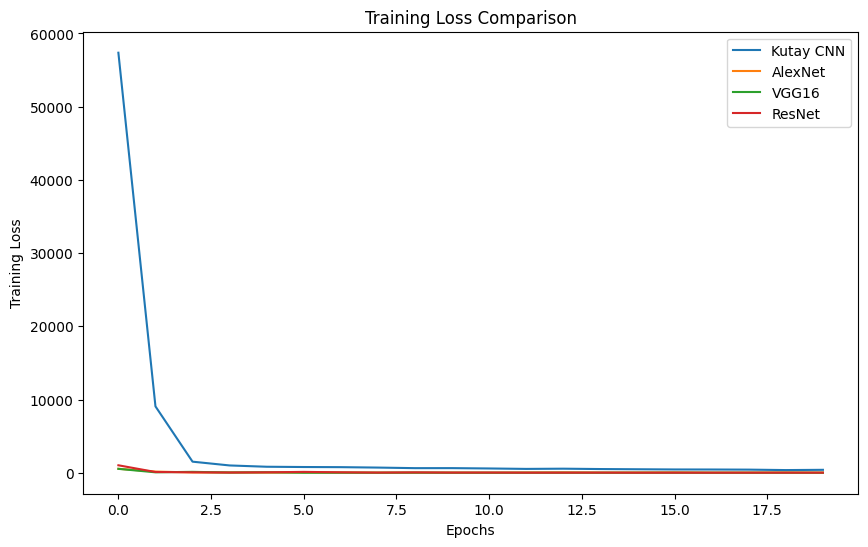

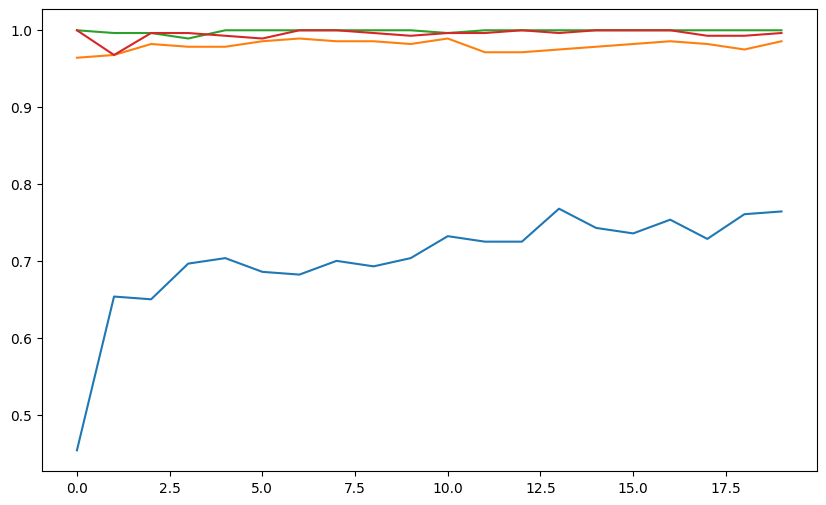

In [ ]:
import matplotlib.pyplot as plt


# Plotting the training curves
plt.figure(figsize=(10, 6))
plt.plot(lost_list_kutay, label='Kutay CNN')
#plt.plot(lost_list_kutay_2, label='Kutay_2 CNN')
plt.plot(lost_list_alexnet, label='AlexNet')
plt.plot(lost_list_vgg16, label='VGG16')
plt.plot(lost_list_resnet, label='ResNet')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()

# Plotting the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(accuracy_list_kutay, label='Kutay CNN')
#plt.plot(accuracy_list_kutay_2, label='Kutay_2 CNN')
plt.plot(accuracy_list_alexnet, label='AlexNet')
plt.plot(accuracy_list_vgg16, label='VGG16')
plt.plot(accuracy_list_resnet, label='ResNet')

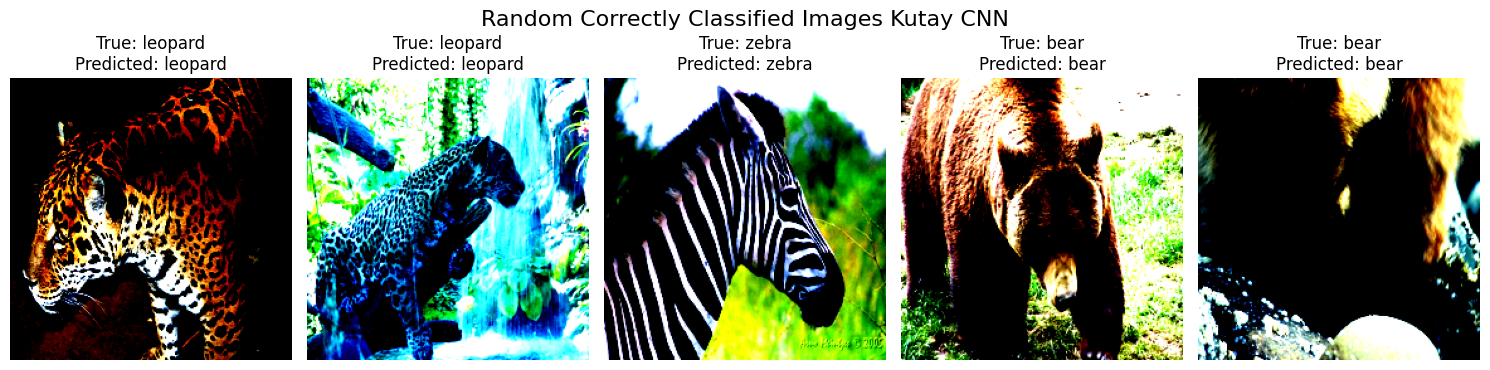

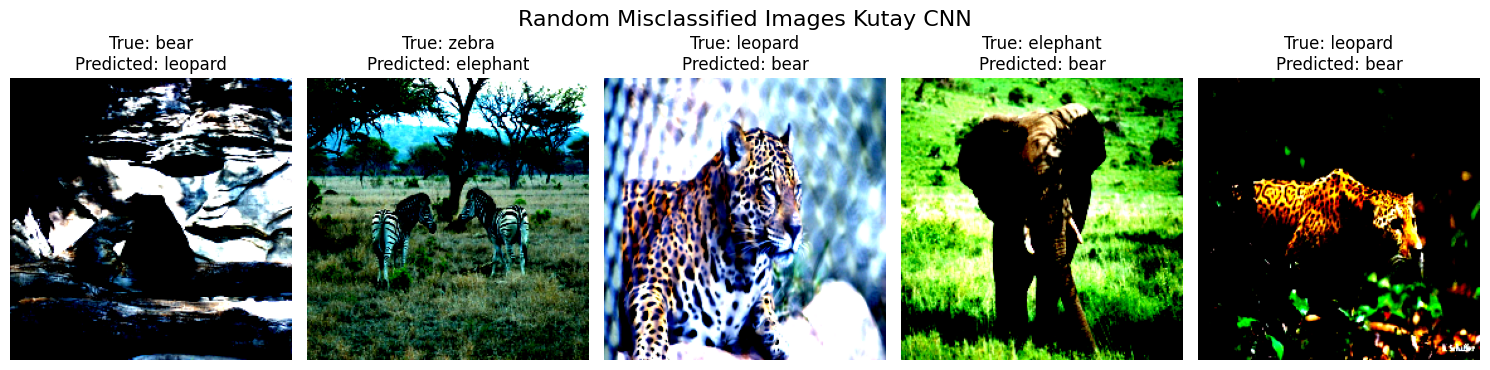

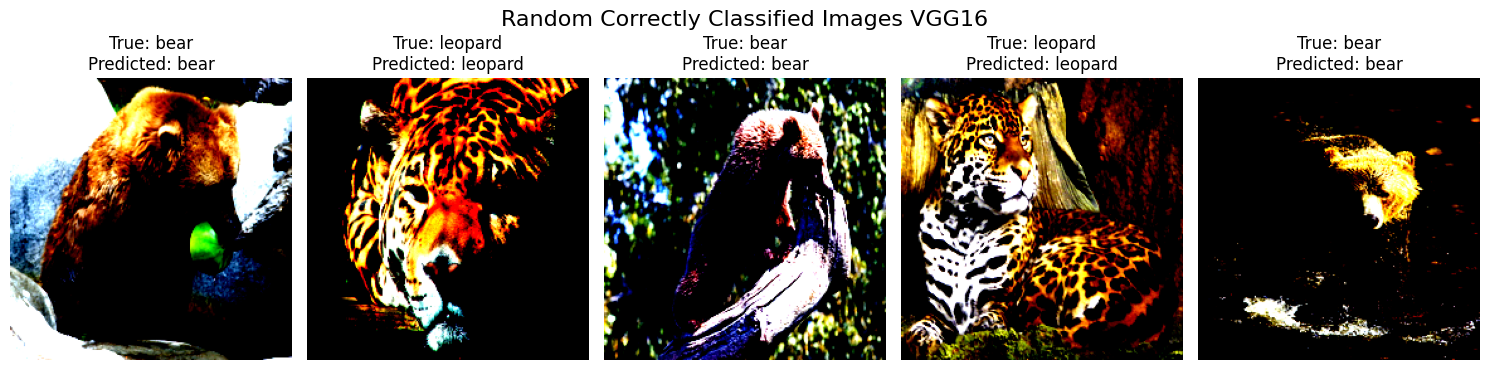

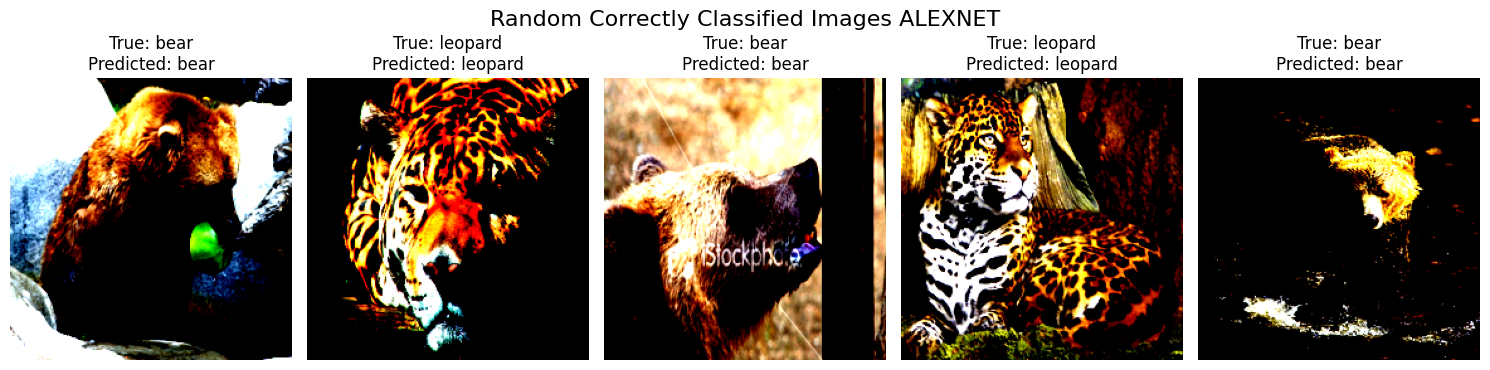

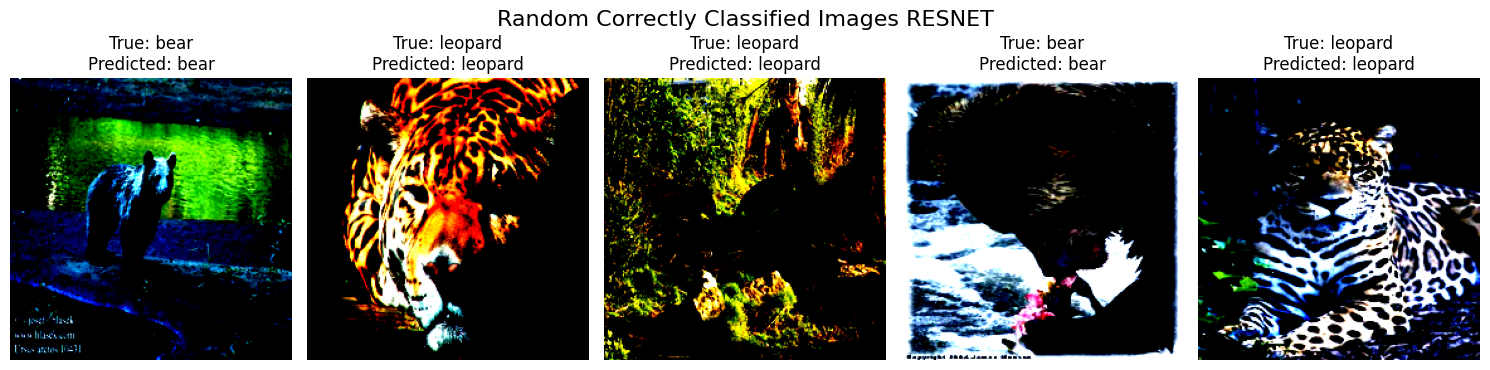

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import random

kutay_correct_images = []
kutay_correct_labels = []
kutay_correct_predicted_labels = []

kutay_misclassified_images = []
kutay_misclassified_labels = []
kutay_misclassified_predicted_labels = []

vgg16_correct_images = []
vgg16_correct_labels = []
vgg16_correct_predicted_labels = []

vgg16_misclassified_images = []
vgg16_misclassified_labels = []
vgg16_misclassified_predicted_labels = []

alexnet_correct_images = []
alexnet_correct_labels = []
alexnet_correct_predicted_labels = []

alexnet_misclassified_images = []
alexnet_misclassified_labels = []
alexnet_misclassified_predicted_labels = []

resnet_correct_images = []
resnet_correct_labels = []
resnet_correct_predicted_labels = []

resnet_misclassified_images = []
resnet_misclassified_labels = []
resnet_misclassified_predicted_labels = []

# Evaluate model1

kutay.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = kutay(images)
        predicted_labels = torch.argmax(outputs, dim=1)

    correct_mask = predicted_labels == labels
    misclassified_mask = ~correct_mask

    kutay_correct_images.extend(images[correct_mask].cpu())
    kutay_correct_labels.extend(labels[correct_mask].cpu())
    kutay_correct_predicted_labels.extend(predicted_labels[correct_mask].cpu())

    kutay_misclassified_images.extend(images[misclassified_mask].cpu())
    kutay_misclassified_labels.extend(labels[misclassified_mask].cpu())
    kutay_misclassified_predicted_labels.extend(predicted_labels[misclassified_mask].cpu())

# Repeat the above steps for model2 and model3


vgg16.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = vgg16(images)
        predicted_labels = torch.argmax(outputs, dim=1)

    correct_mask = predicted_labels == labels
    misclassified_mask = ~correct_mask

    vgg16_correct_images.extend(images[correct_mask].cpu())
    vgg16_correct_labels.extend(labels[correct_mask].cpu())
    vgg16_correct_predicted_labels.extend(predicted_labels[correct_mask].cpu())

    vgg16_misclassified_images.extend(images[misclassified_mask].cpu())
    vgg16_misclassified_labels.extend(labels[misclassified_mask].cpu())
    vgg16_misclassified_predicted_labels.extend(predicted_labels[misclassified_mask].cpu())



alexnet.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = alexnet(images)
        predicted_labels = torch.argmax(outputs, dim=1)

    correct_mask = predicted_labels == labels
    misclassified_mask = ~correct_mask

    alexnet_correct_images.extend(images[correct_mask].cpu())
    alexnet_correct_labels.extend(labels[correct_mask].cpu())
    alexnet_correct_predicted_labels.extend(predicted_labels[correct_mask].cpu())

    alexnet_misclassified_images.extend(images[misclassified_mask].cpu())
    alexnet_misclassified_labels.extend(labels[misclassified_mask].cpu())
    alexnet_misclassified_predicted_labels.extend(predicted_labels[misclassified_mask].cpu())


resnet.eval()

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        outputs = resnet(images)
        predicted_labels = torch.argmax(outputs, dim=1)

    correct_mask = predicted_labels == labels
    misclassified_mask = ~correct_mask

    resnet_correct_images.extend(images[correct_mask].cpu())
    resnet_correct_labels.extend(labels[correct_mask].cpu())
    resnet_correct_predicted_labels.extend(predicted_labels[correct_mask].cpu())

    resnet_misclassified_images.extend(images[misclassified_mask].cpu())
    resnet_misclassified_labels.extend(labels[misclassified_mask].cpu())
    resnet_misclassified_predicted_labels.extend(predicted_labels[misclassified_mask].cpu())




# Select a few random examples from each model's correctly classified images
num_correct_examples = min(len(kutay_correct_images), len(vgg16_correct_images), len(alexnet_correct_images), len(resnet_correct_images), 5)
random_indices = random.sample(range(len(kutay_correct_images)), num_correct_examples)
random_kutay_correct_images = [kutay_correct_images[i] for i in random_indices]
random_kutay_correct_labels = [kutay_correct_labels[i] for i in random_indices]
random_kutay_correct_predicted_labels = [kutay_correct_predicted_labels[i] for i in random_indices]

random_vgg16_correct_images = [vgg16_correct_images[i] for i in random_indices]
random_vgg16_correct_labels = [vgg16_correct_labels[i] for i in random_indices]
random_vgg16_correct_predicted_labels = [vgg16_correct_predicted_labels[i] for i in random_indices]

random_alexnet_correct_images = [alexnet_correct_images[i] for i in random_indices]
random_alexnet_correct_labels = [alexnet_correct_labels[i] for i in random_indices]
random_alexnet_correct_predicted_labels = [alexnet_correct_predicted_labels[i] for i in random_indices]

random_resnet_correct_images = [resnet_correct_images[i] for i in random_indices]
random_resnet_correct_labels = [resnet_correct_labels[i] for i in random_indices]
random_resnet_correct_predicted_labels = [resnet_correct_predicted_labels[i] for i in random_indices]











# Select a few random examples from each model's misclassified images
num_misclassified_examples = min(len(kutay_correct_images), len(vgg16_correct_images), len(alexnet_correct_images), len(resnet_correct_images), 5)
random_indices = random.sample(range(len(kutay_misclassified_images)), num_misclassified_examples)
random_kutay_misclassified_images = [kutay_misclassified_images[i] for i in random_indices]
random_kutay_misclassified_labels = [kutay_misclassified_labels[i] for i in random_indices]
random_kutay_misclassified_predicted_labels = [kutay_misclassified_predicted_labels[i] for i in random_indices]

"""

random_vgg16_misclassified_images = [vgg16_misclassified_images[i] for i in random_indices]
random_vgg16_misclassified_labels = [vgg16_misclassified_labels[i] for i in random_indices]
random_vgg16_misclassified_predicted_labels = [vgg16_misclassified_predicted_labels[i] for i in random_indices]



random_alexnet_misclassified_images = [alexnet_misclassified_images[i] for i in random_indices]
random_alexnet_misclassified_labels = [alexnet_misclassified_labels[i] for i in random_indices]
random_alexnet_misclassified_predicted_labels = [alexnet_misclassified_predicted_labels[i] for i in random_indices]




random_resnet_misclassified_images = [resnet_misclassified_images[i] for i in random_indices]
random_resnet_misclassified_labels = [resnet_misclassified_labels[i] for i in random_indices]
random_resnet_misclassified_predicted_labels = [resnet_misclassified_predicted_labels[i] for i in random_indices]

"""




def plot_images(images, labels, predicted_labels, class_names, title):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 4))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        image = images[i]
        label = labels[i]
        predicted_label = predicted_labels[i]
        class_name = class_names[label]

        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(f"True: {class_name}\nPredicted: {class_names[predicted_label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_images(random_kutay_correct_images, random_kutay_correct_labels, random_kutay_correct_predicted_labels, class_names, "Random Correctly Classified Images Kutay CNN")

# Plot randomly selected misclassified images
plot_images(random_kutay_misclassified_images, random_kutay_misclassified_labels, random_kutay_misclassified_predicted_labels, class_names, "Random Misclassified Images Kutay CNN")



plot_images(random_vgg16_correct_images, random_vgg16_correct_labels, random_vgg16_correct_predicted_labels, class_names, "Random Correctly Classified Images VGG16")

# Plot randomly selected misclassified images
#plot_images(random_vgg16_misclassified_images, random_vgg16_misclassified_labels, random_vgg16_misclassified_predicted_labels, class_names, "Random Misclassified Images VGG16")




plot_images(random_alexnet_correct_images, random_alexnet_correct_labels, random_alexnet_correct_predicted_labels, class_names, "Random Correctly Classified Images ALEXNET")

# Plot randomly selected misclassified images
#plot_images(random_alexnet_misclassified_images, random_alexnet_misclassified_labels, random_alexnet_misclassified_predicted_labels, class_names, "Random Misclassified Images ALEXNET")




plot_images(random_resnet_correct_images, random_resnet_correct_labels, random_resnet_correct_predicted_labels, class_names, "Random Correctly Classified Images RESNET")

# Plot randomly selected misclassified images
#plot_images(random_resnet_misclassified_images, random_resnet_misclassified_labels, random_resnet_misclassified_predicted_labels, class_names, "Random Misclassified Images RESNET")
